Backbone to plot PETHs of PL neurons around the time of the CS for a single rat.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import os

if os.environ['SHELL'] == '/bin/zsh':  # Laptop/Mac
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/TraceFC/')
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/NeuroPy/')
elif os.environ['SHELL'] in ['/bin/sh', '/bin/bash']:  # Linux desktop
    sys.path.append('/data/GitHub/TraceFC/')
    sys.path.append('/data/GitHub/NeuroPy/')
%load_ext autoreload
%autoreload 2

from neuropy.plotting.ca_events import plot_pe_traces
from neuropy.io.minianio import MinianIO
import session_directory as sd
from neuropy.analyses.trace_fc import load_events_from_csv
from neuropy.core.ca_neurons import CaNeuronReg, PairwiseMap, MultiSessionMap, CaNeurons


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set up everything for plotting

## NRK todo: move this function into trace_fc github repo

In [ ]:
def get_events():
    """Function to grab events of a certain type from a .csv file"""
    pass

In [3]:
def load_trace_events(sesh_dir: str, 
                      session_type: str in ['tone_recall', 'control_tone_recall', 'ctx_recall', 'ctx_habituation', 
                                            'tone_habituation', 'training'], 
                      event_type = ['CS+', 'CS-', 'shock', 'sync_tone', 'video', 'baseline'], 
                      return_df: bool = False):
    """
    Loads events of a certain type from a session located in the specified session directory.
    
    """
    assert session_type in ['tone_recall', 'control_tone_recall', 'ctx_recall', 'ctx_habituation', 'tone_habituation', 'training']
    assert event_type in ['CS+', 'CS-', 'shock', 'sync_tone', 'video', 'baseline']
    sesh_dir = Path(sesh_dir)
    
    session_type = 'habituation' if session_type == 'ctx_habituation' else session_type
    # Assemble csv file info into a dataframe.
    csv_files = sorted(sesh_dir.glob('**/' + session_type + '*.csv'))
    event_df_list = []
    for csv_file in csv_files:
        event_df_list.append(load_events_from_csv(csv_file))
    event_df = pd.concat(event_df_list, ignore_index=True)
    
    # Now parse events
    event_str = 'blah'
    if event_type == 'CS+':
        event_str = 'CS_end' if session_type == 'control_tone_recall' else 'CS'
        
    elif event_type == 'CS-':
        assert session_type == 'control_tone_recall', 'Can only specify "CS-" as event_type for "control_tone_recall" session_type'
        event_str = 'CS'
    
    else:
        event_str = event_type
        
    event_starts = event_df[event_df['Event'].str.contains(event_str) & event_df['Event'].str.contains('start')]
    event_ends = event_df[event_df['Event'].str.contains(event_str) & event_df['Event'].str.contains('end')
                         & ~event_df['Event'].str.contains('start')]
    if not return_df:
        return event_starts, event_ends
    else:
        return event_starts, event_ends, event_df
    

# Below needs to be more general - should be able to plot into any axes.

In [4]:
def plot_CS_PETH(sesh_dir, caneurons, session, csname, processed='C', raw='YrA', 
                 neuron_inds: list or np.ndarray or None = None):
    """Plot neural"""
    event_starts, event_ends = load_trace_events(str(sesh_dir), session, csname)
    
    # Grab traces
    proc_traces = getattr(caneurons, processed)
    raw_traces = getattr(caneurons, raw)
    if neuron_inds is not None: # Trim down and re-order if specified
        proc_traces = proc_traces[neuron_inds]
        raw_traces = raw_traces[neuron_inds]
        
    for idc, (proc_trace, raw_trace) in enumerate(zip(proc_traces, raw_traces)):

        fig, ax, _, _, _ = plot_pe_traces(caneurons.t['Timestamps'], proc_trace, event_starts['Timestamp'], 
                                        event_ends=event_ends['Timestamp'], 
                                        raw_trace=raw_trace, end_buffer_sec=40)
        [a.axvline(30, color='r', linestyle='--') for a in ax]
        [a.set_title(f'{csname}: Cell #{idc}') for a in ax]
        fig.suptitle(' '.join(session.capitalize().split('_')))

In [59]:
# NRK make this work for neuron_inds as list or pd.DataFrame
def plot_paired_CS_PETH(caneurons: list, event_starts: list, event_ends: list, 
                        var_plot: str in ['YrA', 'C', 'S'], neuron_inds: list, 
                        cs_types: list, sesh_names: list, cs_color=np.array([1, 0.647, 0, 0.3])):
    
    if np.array(cs_color).ndim == 1:
        cs_color = np.array(cs_color).reshape(1, -1).repeat(len(caneurons), axis=0)
    
    # Check inputs
    ninds = [len(inds) for inds in neuron_inds]
    assert np.array([n == ninds[0] for n in ninds]).all(), '# inds in neuron_inds input must all be the same'
    neuron_inds = np.array(neuron_inds)
        
    # Set up plot
    ncols = len(caneurons)
    nrows = len(neuron_inds[0])    
    fig, ax = plt.subplots(nrows, ncols, figsize=(8.5, 3*nrows))
    
    for ids, (caneuron, starts, ends, inds, color) in enumerate(zip(caneurons, event_starts, event_ends, 
                                                                    neuron_inds, cs_color)):
        traces_plot = getattr(caneuron, var_plot)[inds]  # NRK need to figure out how to not plot any inds = -1 (not mapped)
        cs_name = cs_types[ids]
        sesh_name = sesh_names[ids]
        for idc, trace in enumerate(traces_plot):
            plot_pe_traces(caneuron.t["Timestamps"], trace, event_starts=starts["Timestamp"], 
                           event_ends=ends["Timestamp"],
                          event_color=color, raw_trace=None, end_buffer_sec=40, ax=ax[idc, ids])
            ax[idc, ids].set_title(f'{sesh_name}: {cs_name} Cell #{idc}')
        [a.axvline(30, color='r', linestyle='--') for a in ax[:, ids]]
        
    # overwrite inds == -1 with a blank plot with an x through it.
    silent_bool = ninds == -1
    [a.clear() for a in ax[silent_bool].reshape(-1)]

In [27]:
import itertools

# Specify sessions to plot here
animal = 'Jyn'
sessions = ['Habituation2', 'Training', 'Recall1']
keep = [['good', 'maybe_interneurons']]*len(sessions)
trim = [None]*len(sessions)

# Assemble data
careg = CaNeuronReg([MinianIO(basedir=sd.get_session_dir(animal, session)).trim_neurons(keep=ke, trim=tr) 
                     for session, ke, tr in zip(sessions, keep, trim)], alias=sessions)

# Assemble maps
msm = MultiSessionMap(pwmaps=[careg.load_pairwise_map(sesh1, sesh2) for sesh1, sesh2 in 
                       itertools.combinations(sessions, 2)], sesh_order=sessions)

# Get full map for all sessions
multi_sesh_map = msm.stepwise_reg()

Keeping 38282 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video10 in 12_46_16 folder.
Keeping 152933 good frames found in "good_frames_bool.npy" file
Keeping 47329 good frames found in "good_frames_bool.npy" file


## Now loop through and plot things

## NRK put in ROI overlaid plot here

In [28]:
# First get coactive neurons
coactive_bool = (multi_sesh_map > -1).sum(axis=1) >= 2
coactive_map = multi_sesh_map[coactive_bool]
ncoactive = coactive_map.shape[0]
coactive_map

,Habituation2,Training,Recall1
1,1,1,-1
3,3,2,0
4,4,3,1
5,5,-1,2
7,7,8,4
8,8,-1,5
9,9,9,-1
10,10,11,7
11,11,13,-1
12,12,15,9


In [31]:
coactive_map.values

array([[ 1,  1, -1],
       [ 3,  2,  0],
       [ 4,  3,  1],
       [ 5, -1,  2],
       [ 7,  8,  4],
       [ 8, -1,  5],
       [ 9,  9, -1],
       [10, 11,  7],
       [11, 13, -1],
       [12, 15,  9],
       [14, 16, 10],
       [15, -1, 11]])

In [29]:
## NRK streamline this - should be able to infer some of these variables from other inputs above - will cut down
# on future errors - should be able to at leas get session_type and color!
cs_types = ['CS+', 'CS+', 'CS+']
session_types = ['tone_habituation', 'training', 'tone_recall']
events = [load_trace_events(sd.get_session_dir(animal, session), sesh_type, cs_type) 
          for session, sesh_type, cs_type in zip(sessions, session_types, cs_types)]

0
1
2


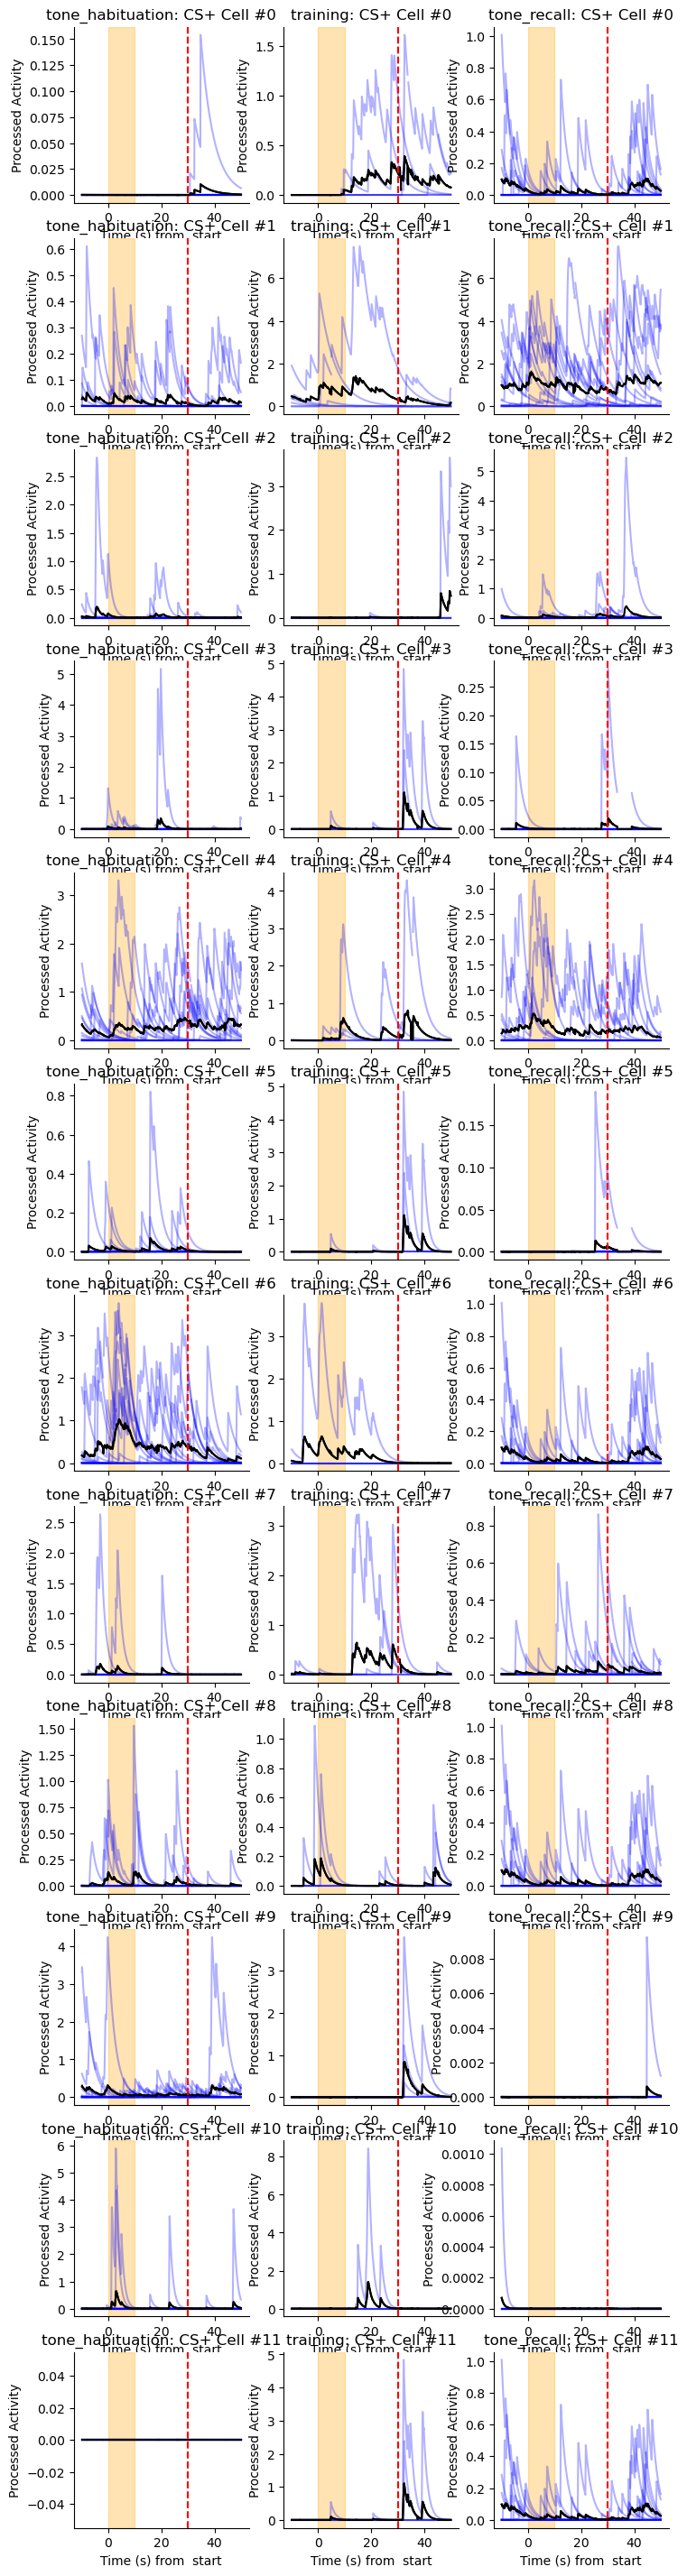

In [60]:
plot_paired_CS_PETH(careg.caneurons, event_starts=[event[0] for event in events], 
                    event_ends=[event[1] for event in events], var_plot='C', 
                    neuron_inds=coactive_map.values.T, cs_types=cs_types, sesh_names=session_types,
                    cs_color=[[1, 0.647, 0, 0.3]]*len(session_types))

## Tone Recall CS+ 

In [ ]:
plot_CS_PETH(sesh_dir, caneurons, 'tone_recall', 'CS+')

## Control Tone Recall CS-

In [ ]:
# Load in event data
plot_CS_PETH(sesh_dir, caneurons, 'control_tone_recall', 'CS-')

## Control Tone Recall CS+

In [ ]:
# Load in event data
plot_CS_PETH(sesh_dir, caneurons, 'control_tone_recall', 'CS+')

## NRK todo:  

~~1) automate loading in events file - concatenate if there are multiple, should be easy to filter out and ignore post-hoc with pandas indexing  ~~
  
~~2) Filter out bad neurons - use "curated_neurons.pkl" file to grab only good ones~~

~~3) Debug RunTimeWarning above~~

4) turn plotting function a function on its own? Maybe keep in notebook for now and just run three separate cells? Yes.

5) Plot each neuron's activity side-by-side across all three conditions.

6) Plot across days - during training, during shock, and during recall1.

7) Fold code bits above into trace_fc class for easier access!!!
